In [1]:
import pandas as pd #Dataframe, Series
import numpy as np

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import seaborn as sns

import graphviz
import pydotplus
import io

from scipy import misc

from sklearn.metrics import accuracy_score

import spotipy
import spotipy.util as util
sp = spotipy.Spotify() 
from spotipy.oauth2 import SpotifyClientCredentials 

%matplotlib inline

C:\Users\dev\AppData\Local\Temp\ipykernel_21396\2862875344.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd #Dataframe, Series


### Login

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util

client_id = '164fe11263da4ce8b39cb03311385ce6'
client_secret = '448a0146206e4b718e4bcc0865efcd29'
redirect_uri='http://localhost:8080/callback'
username = '5865b9eadfc54092'
scope = "user-library-read","playlist-modify-private"


#Credentials to access the Spotify Music Data
from spotipy.oauth2 import SpotifyOAuth
import spotipy

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id,
                                               client_secret,
                                               redirect_uri,
                                               scope = 'user-library-read playlist-read-private'))

### Input Data into Model

- gathering good and bad playlists
- The method signature is sp.user_playlist('user', 'playlist_id')
- To do this go to your good and bad playlists and copy the links.
    - An example spotify link: https://open.spotify.com/user/1287242681/playlist/5OdH7PmotfAO7qDGxKdw3J
    - The user is the number after user/ and the playlist id is after the playlist/.

In [5]:
good_playlist = sp.user_playlist("1287242681", "5OdH7PmotfAO7qDGxKdw3J")
bad_playlist = sp.user_playlist("1287242681", "3ySDAXYGUwRrp8C4ejIm9m")

In [6]:
#Get the good song id's out of the good playlists, need it for the audio features call.
good_tracks = good_playlist["tracks"]
good_songs = good_tracks["items"] 
while good_tracks['next']:
    good_tracks = sp.next(good_tracks)
    for item in good_tracks["items"]:
        good_songs.append(item)
good_ids = [] 
print(len(good_songs))
for i in range(len(good_songs)- 500):
    good_ids.append(good_songs[i]['track']['id'])
# good_tracks

2276


In [7]:
#Now do the same thing for the bad playlist
bad_tracks = bad_playlist["tracks"]
bad_songs = bad_tracks["items"] 
while bad_tracks['next']:
    bad_tracks = sp.next(bad_tracks)
    for item in bad_tracks["items"]:
        bad_songs.append(item)
bad_ids = [] 
print(len(bad_songs))
for i in range(len(bad_songs)):
    bad_ids.append(bad_songs[i]['track']['id'])

2226


In [8]:
audio_features = sp.audio_features(good_ids[0])

for track in audio_features:
    print(track)

{'danceability': 0.796, 'energy': 0.467, 'key': 6, 'loudness': -10.369, 'mode': 1, 'speechiness': 0.181, 'acousticness': 0.173, 'instrumentalness': 0.00411, 'liveness': 0.126, 'valence': 0.516, 'tempo': 107.901, 'type': 'audio_features', 'id': '7eElVgPcxDqmgGrSwVFI74', 'uri': 'spotify:track:7eElVgPcxDqmgGrSwVFI74', 'track_href': 'https://api.spotify.com/v1/tracks/7eElVgPcxDqmgGrSwVFI74', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/7eElVgPcxDqmgGrSwVFI74', 'duration_ms': 197236, 'time_signature': 4}


In [9]:
#Here is where we get all of the audio_features for the tracks on the good and bad playlists.
features = []
inSavedTracks = []
j = 0
for i in range(0,len(good_ids),50):
    print(i)
    audio_features = sp.audio_features(good_ids[i:i+50])
    for track in audio_features:
        print(track)
        features.append(track)
        track = good_songs[j]
        j= j+1
        features[-1]['trackPopularity'] = track['track']['popularity']
        features[-1]['artistPopularity'] = sp.artist(track['track']['artists'][0]['id'])['popularity']
        features[-1]['target'] = 1
j = 0
for i in range(0,len(bad_ids),50):
    print(i)
    audio_features = sp.audio_features(bad_ids[i:i+50])
    for track in audio_features:
        print(track)
        features.append(track)
        track = good_songs[j]
        j= j+1
        features[-1]['trackPopularity'] = track['track']['popularity']
        features[-1]['artistPopularity'] = sp.artist(track['track']['artists'][0]['id'])['popularity']
        features[-1]['target'] = 0

0
{'danceability': 0.796, 'energy': 0.467, 'key': 6, 'loudness': -10.369, 'mode': 1, 'speechiness': 0.181, 'acousticness': 0.173, 'instrumentalness': 0.00411, 'liveness': 0.126, 'valence': 0.516, 'tempo': 107.901, 'type': 'audio_features', 'id': '7eElVgPcxDqmgGrSwVFI74', 'uri': 'spotify:track:7eElVgPcxDqmgGrSwVFI74', 'track_href': 'https://api.spotify.com/v1/tracks/7eElVgPcxDqmgGrSwVFI74', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/7eElVgPcxDqmgGrSwVFI74', 'duration_ms': 197236, 'time_signature': 4}
{'danceability': 0.771, 'energy': 0.431, 'key': 10, 'loudness': -5.423, 'mode': 1, 'speechiness': 0.0577, 'acousticness': 0.287, 'instrumentalness': 2.75e-06, 'liveness': 0.0934, 'valence': 0.268, 'tempo': 107.047, 'type': 'audio_features', 'id': '02oAUzv4M0ItuTDy2RT3IT', 'uri': 'spotify:track:02oAUzv4M0ItuTDy2RT3IT', 'track_href': 'https://api.spotify.com/v1/tracks/02oAUzv4M0ItuTDy2RT3IT', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/02oAUzv4M0ItuTDy2RT3IT', '

### Model Training and Data Modeling

In [10]:
trainingData = pd.DataFrame(features)
trainingData.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,trackPopularity,artistPopularity,target
0,0.796,0.467,6,-10.369,1,0.1810,0.1730,0.004110,0.1260,0.516,...,audio_features,7eElVgPcxDqmgGrSwVFI74,spotify:track:7eElVgPcxDqmgGrSwVFI74,https://api.spotify.com/v1/tracks/7eElVgPcxDqm...,https://api.spotify.com/v1/audio-analysis/7eEl...,197236,4,62,75.0,1
1,0.771,0.431,10,-5.423,1,0.0577,0.2870,0.000003,0.0934,0.268,...,audio_features,02oAUzv4M0ItuTDy2RT3IT,spotify:track:02oAUzv4M0ItuTDy2RT3IT,https://api.spotify.com/v1/tracks/02oAUzv4M0It...,https://api.spotify.com/v1/audio-analysis/02oA...,189796,4,65,75.0,1
2,0.664,0.382,0,-9.977,1,0.0470,0.2390,0.007490,0.0943,0.126,...,audio_features,5q4BpnMrYEFzLO0dYODj6J,spotify:track:5q4BpnMrYEFzLO0dYODj6J,https://api.spotify.com/v1/tracks/5q4BpnMrYEFz...,https://api.spotify.com/v1/audio-analysis/5q4B...,271088,4,66,75.0,1
3,0.587,0.229,10,-11.254,0,0.1280,0.9200,0.000000,0.1000,0.379,...,audio_features,6Kkt27YmFyIFrcX3QXFi2o,spotify:track:6Kkt27YmFyIFrcX3QXFi2o,https://api.spotify.com/v1/tracks/6Kkt27YmFyIF...,https://api.spotify.com/v1/audio-analysis/6Kkt...,171728,4,75,75.0,1
4,0.487,0.445,1,-10.959,0,0.1130,0.0328,0.010400,0.0778,0.180,...,audio_features,1Dp7JGFNjvg8Nk0CtMCcnr,spotify:track:1Dp7JGFNjvg8Nk0CtMCcnr,https://api.spotify.com/v1/tracks/1Dp7JGFNjvg8...,https://api.spotify.com/v1/audio-analysis/1Dp7...,367391,4,63,75.0,1


In [11]:
train, test = train_test_split(trainingData, test_size = 0.15)
print("Training size: {}, Test size: {}".format(len(train),len(test)))

Training size: 3401, Test size: 601


In [12]:
# Custom Color Palette for graphs
red_blue = ['#19B5FE', '#EF4836']
palette = sns.color_palette(red_blue)
sns.set_palette(palette)
sns.set_style('white')

In [13]:
pos_tempo = trainingData[trainingData['target'] == 1]['tempo']
neg_tempo = trainingData[trainingData['target'] == 0]['tempo']
pos_dance = trainingData[trainingData['target'] == 1]['danceability']
neg_dance = trainingData[trainingData['target'] == 0]['danceability']
pos_duration = trainingData[trainingData['target'] == 1]['duration_ms']
neg_duration = trainingData[trainingData['target'] == 0]['duration_ms']
pos_loudness = trainingData[trainingData['target'] == 1]['loudness']
neg_loudness = trainingData[trainingData['target'] == 0]['loudness']
pos_speechiness = trainingData[trainingData['target'] == 1]['speechiness']
neg_speechiness = trainingData[trainingData['target'] == 0]['speechiness']
pos_valence = trainingData[trainingData['target'] == 1]['valence']
neg_valence = trainingData[trainingData['target'] == 0]['valence']
pos_energy = trainingData[trainingData['target'] == 1]['energy']
neg_energy = trainingData[trainingData['target'] == 0]['energy']
pos_acousticness = trainingData[trainingData['target'] == 1]['acousticness']
neg_acousticness = trainingData[trainingData['target'] == 0]['acousticness']
pos_key = trainingData[trainingData['target'] == 1]['key']
neg_key = trainingData[trainingData['target'] == 0]['key']
pos_instrumentalness = trainingData[trainingData['target'] == 1]['instrumentalness']
neg_instrumentalness = trainingData[trainingData['target'] == 0]['instrumentalness']
pos_popularity = trainingData[trainingData['target'] == 1]['trackPopularity']
neg_popularity = trainingData[trainingData['target'] == 0]['trackPopularity']

In [14]:
print(pos_tempo)


0       107.901
1       107.047
2       123.214
3        75.670
4        97.031
         ...   
1771    145.994
1772    109.986
1773    120.028
1774    122.028
1775    101.033
Name: tempo, Length: 1776, dtype: float64


In [15]:
print(neg_tempo)

1776    127.467
1777    126.722
1778     84.421
1779    176.463
1780    136.117
         ...   
3997    121.435
3998    153.678
3999    106.462
4000    113.784
4001    141.878
Name: tempo, Length: 2226, dtype: float64


In [16]:
print(pos_popularity)
print(neg_popularity)

0       62
1       65
2       66
3       75
4       63
        ..
1771    31
1772    21
1773     0
1774     0
1775     0
Name: trackPopularity, Length: 1776, dtype: int64
1776    62
1777    65
1778    66
1779    75
1780    63
        ..
3997     0
3998    30
3999    21
4000    53
4001     0
Name: trackPopularity, Length: 2226, dtype: int64


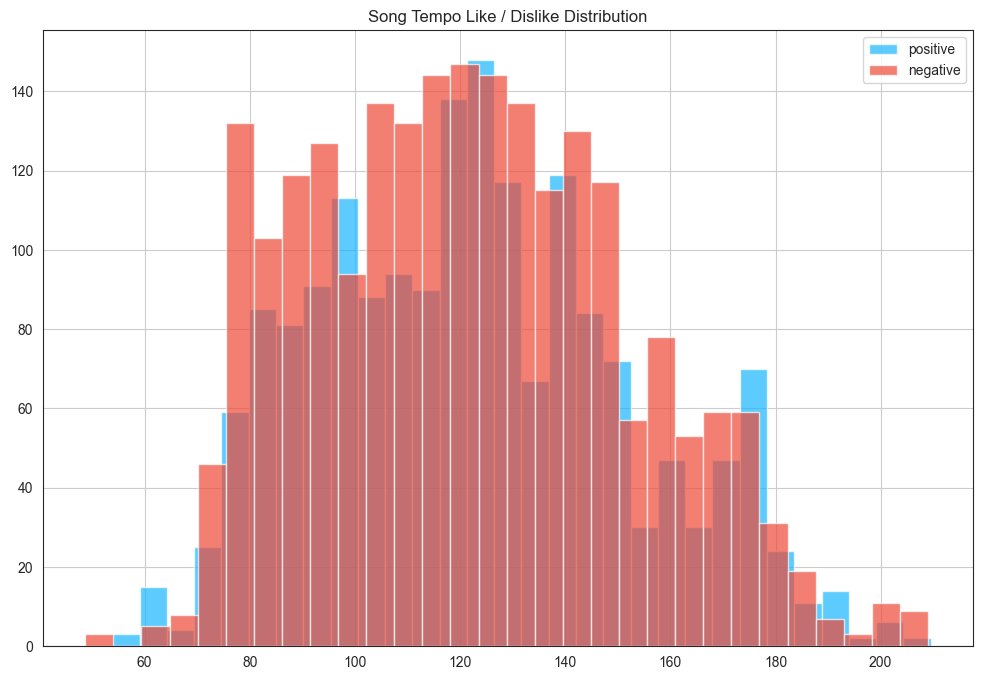

In [17]:
fig = plt.figure(figsize=(12,8))
plt.title("Song Tempo Like / Dislike Distribution")
pos_tempo.hist(alpha=0.7, bins=30, label='positive')
neg_tempo.hist(alpha=0.7, bins=30, label='negative')
plt.legend(loc='upper right')

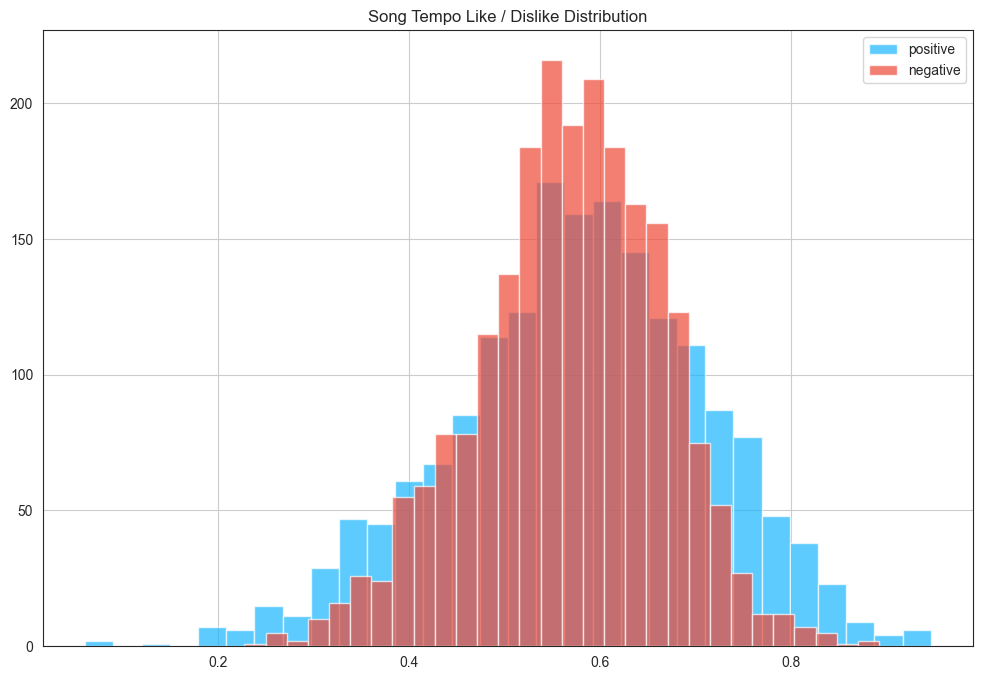

In [18]:
fig = plt.figure(figsize=(12,8))
plt.title("Song Tempo Like / Dislike Distribution")
pos_dance.hist(alpha=0.7, bins=30, label='positive')
neg_dance.hist(alpha=0.7, bins=30, label='negative')
plt.legend(loc='upper right')

<Axes: >

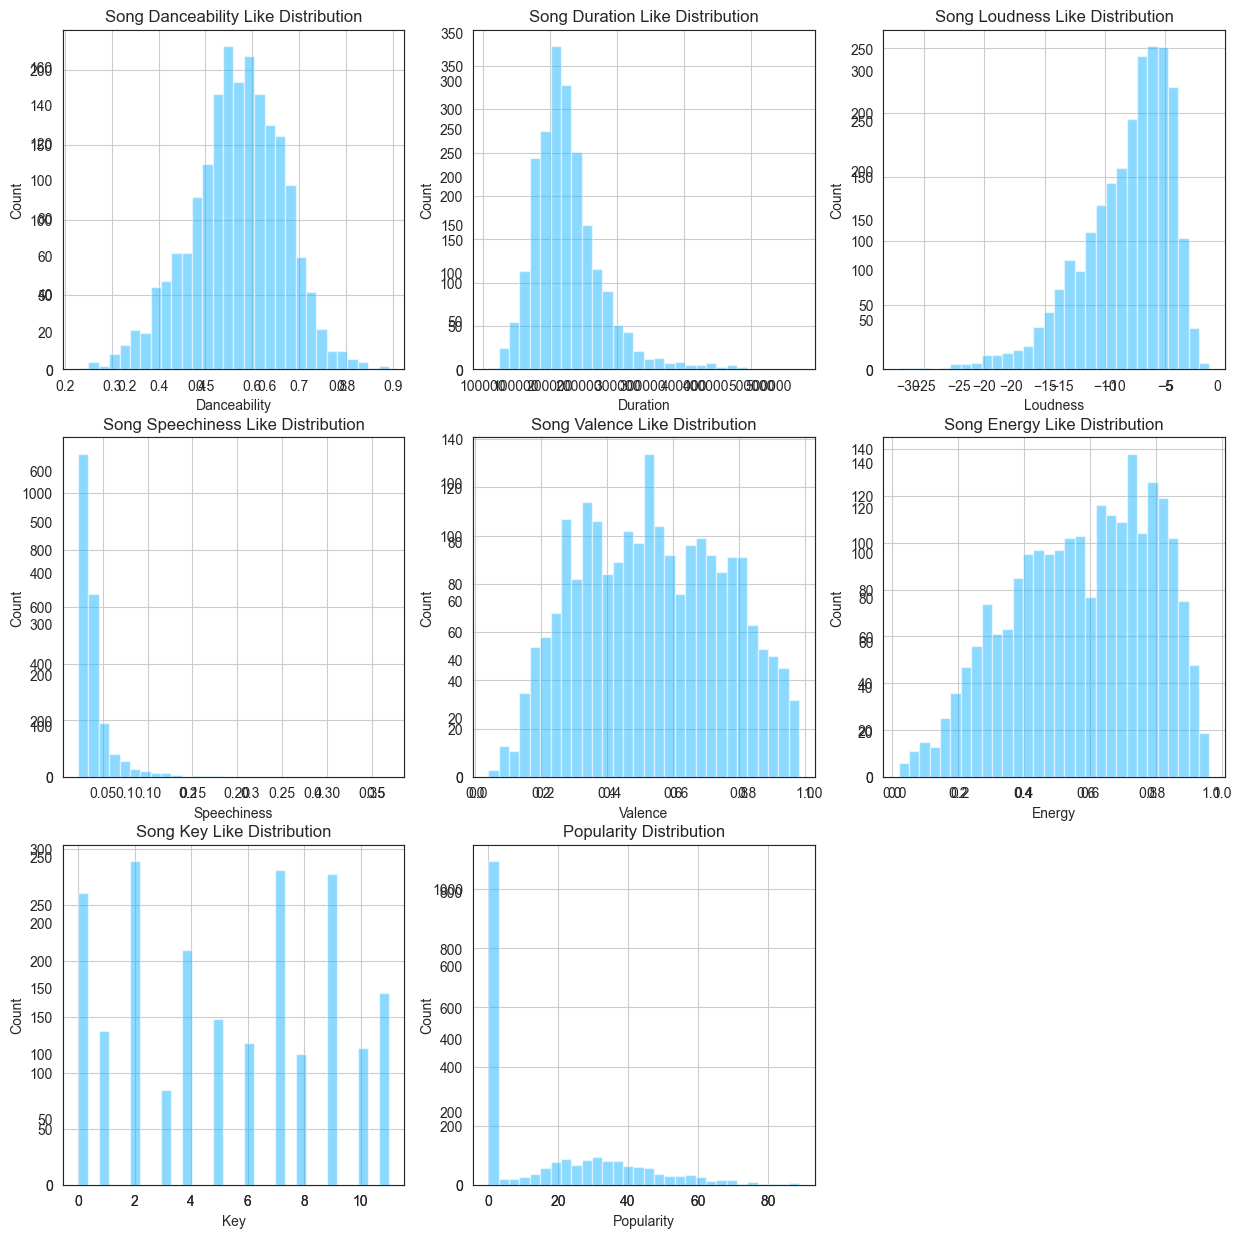

In [19]:
fig2 = plt.figure(figsize=(15,15))

#Danceability
ax3 = fig2.add_subplot(331)
ax3.set_xlabel('Danceability')
ax3.set_ylabel('Count')
ax3.set_title('Song Danceability Like Distribution')
pos_dance.hist(alpha= 0.5, bins=30)
ax4 = fig2.add_subplot(331)
neg_dance.hist(alpha= 0.5, bins=30)

#Duration_ms
ax5 = fig2.add_subplot(332)
ax5.set_xlabel('Duration')
ax5.set_ylabel('Count')
ax5.set_title('Song Duration Like Distribution')
pos_duration.hist(alpha= 0.5, bins=30)
ax6 = fig2.add_subplot(332)
neg_duration.hist(alpha= 0.5, bins=30)

#Loudness
ax7 = fig2.add_subplot(333)
ax7.set_xlabel('Loudness')
ax7.set_ylabel('Count')
ax7.set_title('Song Loudness Like Distribution')
pos_loudness.hist(alpha= 0.5, bins=30)
ax8 = fig2.add_subplot(333)
neg_loudness.hist(alpha= 0.5, bins=30)

#Speechiness
ax9 = fig2.add_subplot(334)
ax9.set_xlabel('Speechiness')
ax9.set_ylabel('Count')
ax9.set_title('Song Speechiness Like Distribution')
pos_speechiness.hist(alpha= 0.5, bins=30)
ax10 = fig2.add_subplot(334)
neg_speechiness.hist(alpha= 0.5, bins=30)

#Valence
ax11 = fig2.add_subplot(335)
ax11.set_xlabel('Valence')
ax11.set_ylabel('Count')
ax11.set_title('Song Valence Like Distribution')
pos_valence.hist(alpha= 0.5, bins=30)
ax12 = fig2.add_subplot(335)
neg_valence.hist(alpha= 0.5, bins=30)

#Energy
ax13 = fig2.add_subplot(336)
ax13.set_xlabel('Energy')
ax13.set_ylabel('Count')
ax13.set_title('Song Energy Like Distribution')
pos_energy.hist(alpha= 0.5, bins=30)
ax14 = fig2.add_subplot(336)
neg_energy.hist(alpha= 0.5, bins=30)

#Key
ax15 = fig2.add_subplot(337)
ax15.set_xlabel('Key')
ax15.set_ylabel('Count')
ax15.set_title('Song Key Like Distribution')
pos_key.hist(alpha= 0.5, bins=30)
ax16 = fig2.add_subplot(337)
neg_key.hist(alpha= 0.5, bins=30)

#Key
ax15 = fig2.add_subplot(338)
ax15.set_xlabel('Popularity')
ax15.set_ylabel('Count')
ax15.set_title('Popularity Distribution')
pos_popularity.hist(alpha= 0.5, bins=30)
ax16 = fig2.add_subplot(338)
neg_popularity.hist(alpha= 0.5, bins=30)


In [20]:
#Define the set of features that we want to look at
features = ["danceability", "loudness", "valence", "energy", "instrumentalness", "acousticness", "key", "speechiness","duration_ms"]

In [21]:
#Split the data into x and y test and train sets to feed them into a bunch of classifiers!
x_train = train[features]
y_train = train["target"]

x_test = test[features]
y_test = test["target"]

In [22]:
c = DecisionTreeClassifier(min_samples_split=100)
dt = c.fit(x_train, y_train)

In [23]:
def show_tree(InputTree, features, path):
    f = io.StringIO()
    tree.export_graphviz(InputTree, out_file=f, feature_names=features)
    pydotplus.graph_from_dot_data(f.getvalue()).write_png(path)
    img = misc.imread(path)
    plt.rcParams["figure.figsize"] = (20,20)
    plt.imshow(img)
# TODO install 
# show_tree(dt, features, "dec_tree.png")

In [24]:
y_pred = c.predict(x_test)
score = accuracy_score(y_test, y_pred) * 100
print("Accuracy using Decision Tree: ", round(score, 1), "%")

Accuracy using Decision Tree:  79.5 %


In [25]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(3)
knn.fit(x_train, y_train)
knn_pred = c.predict(x_test)
score = accuracy_score(y_test, knn_pred) * 100
print("Accuracy using Knn Tree: ", round(score, 1), "%")

Accuracy using Knn Tree:  79.5 %


In [26]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(x_train, y_train)
mlp_pred = mlp.predict(x_test)
score = accuracy_score(y_test, mlp_pred) * 100
print("Accuracy using mlp Tree: ", round(score, 1), "%")

Accuracy using mlp Tree:  53.7 %


In [27]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
forest.fit(x_train, y_train)
forest_pred = forest.predict(x_test)
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, forest_pred) * 100
print("Accuracy using random forest: ", round(score, 1), "%")

Accuracy using random forest:  80.4 %


In [28]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100)
ada.fit(x_train, y_train)
ada_pred = ada.predict(x_test)
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, ada_pred) * 100
print("Accuracy using ada: ", round(score, 1), "%")

c:\Users\dev\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy using ada:  83.5 %


In [29]:
from sklearn.naive_bayes import GaussianNB
gauss = GaussianNB()
gauss.fit(x_train, y_train)
gauss_pred = gauss.predict(x_test)
score = accuracy_score(y_test, gauss_pred)*100
print("Accuracy using gauss: ", round(score, 1), "%")

Accuracy using gauss:  58.1 %


In [30]:
from sklearn.cluster import KMeans
k_means = KMeans(n_clusters=3, random_state=0)
k_means.fit(x_train, y_train)
predicted= k_means.predict(x_test)
score = accuracy_score(y_test, predicted)*100
print("Accuracy using Kmeans: ", round(score, 1), "%")

Accuracy using Kmeans:  28.1 %


In [31]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=.1, max_depth=1, random_state=0)
gbc.fit(x_train, y_train)
predicted = gbc.predict(x_test)
score = accuracy_score(y_test, predicted)*100
print("Accuracy using Gbc: ", round(score, 1), "%")

Accuracy using Gbc:  82.7 %


In [32]:
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# qda = QuadraticDiscriminantAnalysis()
# qda.fit(x_train, y_train)
# qda_pred = qda.predict(x_test)
# score = accuracy_score(y_test, qda_pred)*100
# print("Accuracy using qda: ", round(score, 1), "%")

In [33]:
# from sklearn.svm import SVC
# svc_lin = SVC(kernel="linear", C=0.025)
# svc_lin.fit(x_train, y_train)
# svc_pred = svc_lin.predict(x_test)
# from sklearn.metrics import accuracy_score
# score = accuracy_score(y_test, svc_pred) * 100
# print("Accuracy using svc linear: ", round(score, 1), "%")

In [34]:
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF
# gpc = GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True)
# gpc.fit(x_train, y_train)
# gpc_pred = gpc.predict(x_test)
# from sklearn.metrics import accuracy_score
# score = accuracy_score(y_test, gpc_pred) * 100
# print("Accuracy using gpc: ", round(score, 1), "%")

In [37]:
client_id = '164fe11263da4ce8b39cb03311385ce6'
client_secret = '448a0146206e4b718e4bcc0865efcd29'
redirect_uri='http://localhost:8080/callback'
username = '5865b9eadfc54092'
scope = 'playlist-modify-private playlist-modify-public playlist-read-private user-library-read'


#Credentials to access the Spotify Music Data
from spotipy.oauth2 import SpotifyOAuth
import spotipy

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id,
                                               client_secret,
                                               redirect_uri,
                                               scope = 'user-library-read playlist-read-private'))

In [39]:
playlistToFindSongsYouLikeIn = sp.user_playlist("spotify", "37i9dQZEVXcFqDuJHHirGk")

newPlaylist_tracks = playlistToFindSongsYouLikeIn["tracks"]
newPlaylist_songs = newPlaylist_tracks["items"] 
while newPlaylist_tracks['next']:
    newPlaylist_tracks = sp.next(newPlaylist_tracks)
    for song in newPlaylist_tracks["items"]:
        newPlaylist_songs.append(song)
        
newPlaylist_song_ids = [] 
print(len(newPlaylist_songs))
for i in range(len(newPlaylist_songs)):
    newPlaylist_song_ids.append(newPlaylist_songs[i]['track']['id'])
    
newPlaylist_features = []
j = 0
for i in range(0,len(newPlaylist_song_ids),50):
    audio_features = sp.audio_features(newPlaylist_song_ids[i:i+50])
    for track in audio_features:
        track['song_title'] = newPlaylist_songs[j]['track']['name']
        track['artist'] = newPlaylist_songs[j]['track']['artists'][0]['name']
        j= j + 1
        newPlaylist_features.append(track)
print(len(newPlaylist_features))

playlistToLookAtFeatures = pd.DataFrame(newPlaylist_features)

30
30


In [40]:
pred = gbc.predict(playlistToLookAtFeatures[features])

likedSongs = 0
i = 0
for prediction in pred:
    if(prediction == 1):
        print ("Song: " + playlistToLookAtFeatures["song_title"][i] + ", By: "+ playlistToLookAtFeatures["artist"][i])
        #sp.user_playlist_add_tracks("1287242681", "7eIX1zvtpZR3M3rYFVA7DF", [test['id'][i]])
        likedSongs= likedSongs + 1
    i = i +1
    

Song: Pancakes for Dinner, By: Lizzy McAlpine
Song: America's Sweetheart, By: Elle King
Song: What Was, By: Benson Boone
Song: Can We Pretend That We’re Good?, By: Daniel Seavey
Song: god of the sunsets, By: SEB
Song: I Forget, By: Austin Giorgio
Song: Kinda Over It, By: Maddy Hicks
Song: Be Your Man, By: G Flip
Song: 23, By: Wilfred
Song: Baby Blue, By: Rence
Song: Happy?, By: Caye
Song: I Would've, By: Jessie Murph
Song: Flowers Need Rain, By: Preston Pablo
